In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [2]:
df_train = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

In [3]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [4]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [5]:
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [6]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [7]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
        print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
        print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
        print('CONFUSION MATRIX\n')
        print(pd.crosstab(y_test_true, y_test_pred))
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [22]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    if get_top is not None:
        feature_importances=feature_importances.sort_values('importance', ascending=False)[:get_top]
    else:          
        feature_importances = feature_importances.sort_values('importance', ascending=False)
    
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances)
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

In [9]:
TARGET_NAME = 'Credit Default'

In [10]:
df_train[TARGET_NAME].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [11]:
import catboost as catb

In [12]:
cat = catb.CatBoostRegressor()

In [13]:
class FeatureImputer:
    count = 0
    def __init__(self):
        self.count += 1
        
    def fit(self, X, y = None):
        self.dummy_col=['Home Ownership', 'Term', 'Years in current job', 'Purpose']
        self.purpose_change='vacation'
        self.mean=int(X['Months since last delinquent'].mean())
        self.mean=int(X['Annual Income'].mean())
        self.mean=int(X['Credit Score'].mean())
        self.mean=int(X['Bankruptcies'].mean())
        return self
    def transform(self, X):
        X_trans=X.copy()
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change
        X_trans.loc[(X_trans['Annual Income'].notna())&(X_trans['Months since last delinquent'].isna()), 'Months since last delinquent']=self.mean
        
        X_trans.fillna(0, inplace=True)
        X_trans=pd.get_dummies(X_trans, columns=self.dummy_col, drop_first=True)

        return X_trans
        

In [14]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_NAME],
                               random_state=12)

In [15]:
imputer=FeatureImputer()
train=imputer.fit(train).transform(train)
val=imputer.transform(val)

In [16]:
X_train, y_train, X_val, y_val = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME], val.drop(TARGET_NAME, axis=1), val[TARGET_NAME]

In [18]:
rfc=RandomForestClassifier(max_depth=4, class_weight={0:1,1:2.55}, random_state=100)
rfc.fit(X_train, y_train)
evaluate_preds(rfc, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      4310
           1       0.47      0.69      0.56      1690

    accuracy                           0.70      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.75      0.70      0.71      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1077
           1       0.43      0.65      0.52       423

    accuracy                           0.66      1500
   macro avg       0.63      0.66      0.63      1500
weighted avg       0.72      0.66      0.68      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               721  356
1               149  274


In [20]:
estimator = rfc.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file


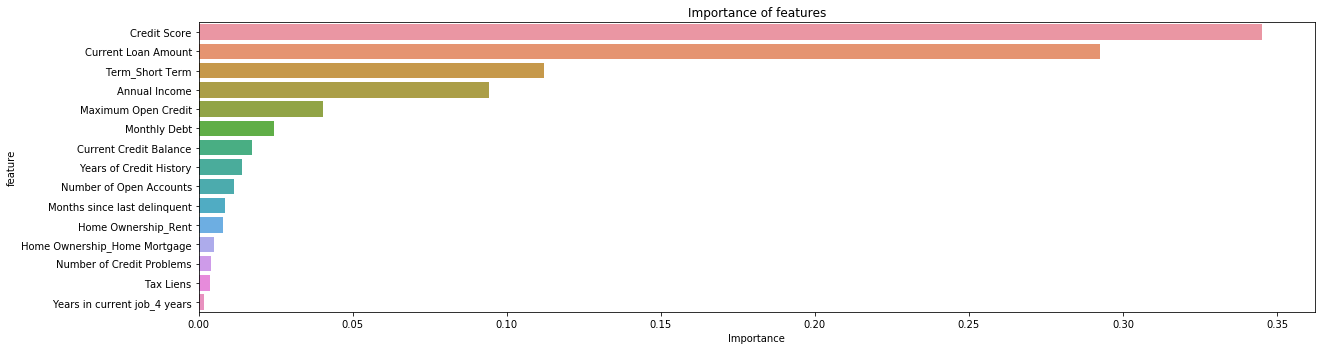

In [23]:
important_features_top = show_feature_importances(X_train.columns,
                                                  rfc.feature_importances_, get_top=15)

In [24]:
X_test=imputer.transform(df_test)
y_pred=rfc.predict(X_test)
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred})

In [25]:
RESULT_PATH='./predictions.csv'
result.to_csv(RESULT_PATH, index=False)